In [1]:
import pandas as pd

# Load the data
url1="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_997120a21a134b84b238e63c2c1d39bb.csv"
per_capita=pd.read_csv(url1)

url2="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_73b547d8f14f485ea46b25c7a6e18734.csv"
population=pd.read_csv(url2)

In [2]:
per_capita.head()

,label,CO2 Emissions
0,2016,15.502204
1,2015,15.989866
2,2014,16.416576
3,2013,16.362224
4,2012,16.193429


In [3]:
# Rename the "label" column as "Year"
per_capita=per_capita.rename(columns={"label":"Year","CO2 Emissions":"Per_Capita_Emission"})
per_capita=per_capita.iloc[::-1].reset_index(drop=True)
per_capita.head()

,Year,Per_Capita_Emission
0,1960,15.999779
1,1961,15.681256
2,1962,16.013937
3,1963,16.482762
4,1964,16.968119


In [4]:
population.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,58726.0,59063.0,59440.0,59840.0,60243.0,60528.0,60657.0,60586.0,60366.0,60103.0,59980.0,60096.0,60567.0,61345.0,62201.0,62836.0,63026.0,62644.0,61833.0,61079.0,61032.0,62149.0,64622.0,68235.0,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,97017.0,98737.0,100031.0,100834.0,101222.0,101358.0,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,106314.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,10399926.0,10637063.0,10893776.0,11173642.0,11475445.0,11791215.0,12108963.0,12412950.0,12689160.0,12943093.0,13171306.0,13341198.0,13411056.0,13356511.0,13171673.0,12882528.0,12537730.0,12204292.0,11938208.0,11736179.0,11604534.0,11618005.0,11868877.0,12412308.0,13299017.0,14485546.0,15816603.0,17075727.0,18110657.0,18853437.0,19357126.0,19737765.0,20170844.0,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,38041754.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,5774243.0,5771652.0,5803254.0,5890365.0,6040777.0,6248552.0,6496962.0,6761380.0,7024000.0,7279509.0,7533735.0,7790707.0,8058067.0,8341289.0,8640446.0,8952950.0,9278096.0,9614754.0,9961997.0,10320111.0,10689250.0,11068050.0,11454777.0,11848386.0,12248901.0,12657366.0,13075049.0,13503747.0,13945206.0,14400719.0,14871570.0,15359601.0,15866869.0,16395473.0,16945753.0,17519417.0,18121479.0,18758145.0,19433602.0,20149901.0,20905363.0,21695634.0,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,31825295.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0,2726056.0,2784278.0,2843960.0,2904429.0,2964762.0,3022635.0,3083605.0,3142336.0,3227943.0,3286542.0,3266790.0,3247039.0,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,21890.0,23058.0,24276.0,25559.0,26892.0,28232.0,29520.0,30705.0,31777.0,32771.0,33737.0,34818.0,36067.0,37500.0,39114.0,40867.0,42706.0,44600.0,46517.0,48455.0,50434.0,52448.0,54509.0,56671.0,58888.0,60971.0,62677.0,63850.0,64360.0,64327.0,64142.0,64370.0,65390.0,67341.0,70049.0,73182.0,76244.0,78867.0,80993.0,82684.0,83862.0,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,77142.0,NaN


In [5]:
# Select only population data about the U.S.
us=population[population["Country Name"]=='United States']
us

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
249,United States,USA,"Population, total",SP.POP.TOTL,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,196560000.0,198712000.0,200706000.0,202677000.0,205052000.0,207661000.0,209896000.0,211909000.0,213854000.0,215973000.0,218035000.0,220239000.0,222585000.0,225055000.0,227225000.0,229466000.0,231664000.0,233792000.0,235825000.0,237924000.0,240133000.0,242289000.0,244499000.0,246819000.0,249623000.0,252981000.0,256514000.0,259919000.0,263126000.0,266278000.0,269394000.0,272657000.0,275854000.0,279040000.0,282162411.0,284968955.0,287625193.0,290107933.0,292805298.0,295516599.0,298379912.0,301231207.0,304093966.0,306771529.0,309321666.0,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0,NaN


In [6]:
us=us.drop(["Country Name","Country Code","Indicator Name","Indicator Code"],axis=1)
us

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
249,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,196560000.0,198712000.0,200706000.0,202677000.0,205052000.0,207661000.0,209896000.0,211909000.0,213854000.0,215973000.0,218035000.0,220239000.0,222585000.0,225055000.0,227225000.0,229466000.0,231664000.0,233792000.0,235825000.0,237924000.0,240133000.0,242289000.0,244499000.0,246819000.0,249623000.0,252981000.0,256514000.0,259919000.0,263126000.0,266278000.0,269394000.0,272657000.0,275854000.0,279040000.0,282162411.0,284968955.0,287625193.0,290107933.0,292805298.0,295516599.0,298379912.0,301231207.0,304093966.0,306771529.0,309321666.0,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0,NaN


In [7]:
us=us.T.reset_index().rename(columns={"index":"Year",249:"Population"})
us.head()

,Year,Population
0,1960,180671000.0
1,1961,183691000.0
2,1962,186538000.0
3,1963,189242000.0
4,1964,191889000.0


In [8]:
# The latest year for the per capita emission data is 2016. So, select data that is up to 2016 from the population data only.
us=us[:len(per_capita)]
us.head()

,Year,Population
0,1960,180671000.0
1,1961,183691000.0
2,1962,186538000.0
3,1963,189242000.0
4,1964,191889000.0


In [9]:
# Merge the per capita data and population data, then compute the total emission by multiplying the per capita amount by population size.
df=pd.concat([per_capita,us[["Population"]]],axis=1)
df["Total_Emission"]=df["Per_Capita_Emission"]*df["Population"]
df.head()

,Year,Per_Capita_Emission,Population,Total_Emission
0,1960,15.999779,180671000.0,2.890696e+09
1,1961,15.681256,183691000.0,2.880506e+09
2,1962,16.013937,186538000.0,2.987208e+09
3,1963,16.482762,189242000.0,3.119231e+09
4,1964,16.968119,191889000.0,3.255995e+09


In [10]:
# Visualize annual CO2 emission in the U.S. from 1960 to 2016
import plotly.express as px
fig = px.bar(df, x='Year', y='Total_Emission',title="CO2 Emissions in the U.S. in Metric Tons, 1960-2016")
fig.show()

In [11]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [27]:
# build an ARIMA model for the time series. 
X = df[["Total_Emission"]].values
size = int(len(X) * 0.70) # Use 70% of the data for training.

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Train, test the model and print out the MAPE.
for t in range(len(test)):
	model = ARIMA(history, order=(3,1,0))
	model_fit = model.fit(disp=-1)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
mape = np.mean(np.abs(predictions -test )/np.abs(test))
print('MAPE: '+str(mape))

MAPE: 0.0236825343088424


###### The MAPE is less than 10%. In fact, it is a lot smaller than 10%. So, the ARIMA model is decent.

`



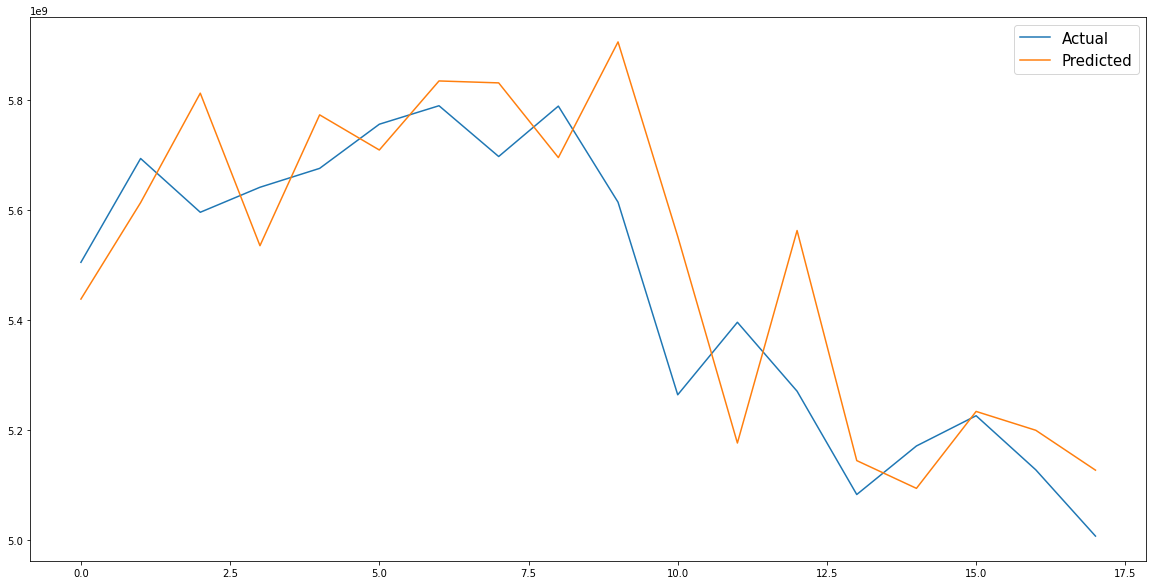

In [28]:
# Plot the actual observations in the test data and their predictions by the model. 
plt.figure(figsize=(20,10))
plt.plot(test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend(fontsize=15)
plt.show()

###### As shown, the predictions are one period ahead of the actual observations and are not very useful for predictions. Shift the predictions backward  by one period.

In [29]:
predictions=pd.DataFrame(predictions).shift(-1).dropna().rename(columns={0:"Predicted Total Emission"})
predictions

,Predicted Total Emission
0,5.613326e+09
1,5.812588e+09
2,5.534949e+09
3,5.773121e+09
4,5.709135e+09
5,5.834838e+09
6,5.831325e+09
7,5.695356e+09
8,5.905917e+09
9,5.551921e+09


In [30]:
test=pd.DataFrame(test).rename(columns={0:"Total_Emission"})
test

,Total_Emission
0,5.504669e+09
1,5.693685e+09
2,5.595794e+09
3,5.641309e+09
4,5.675702e+09
5,5.756075e+09
6,5.789727e+09
7,5.697286e+09
8,5.789031e+09
9,5.614111e+09


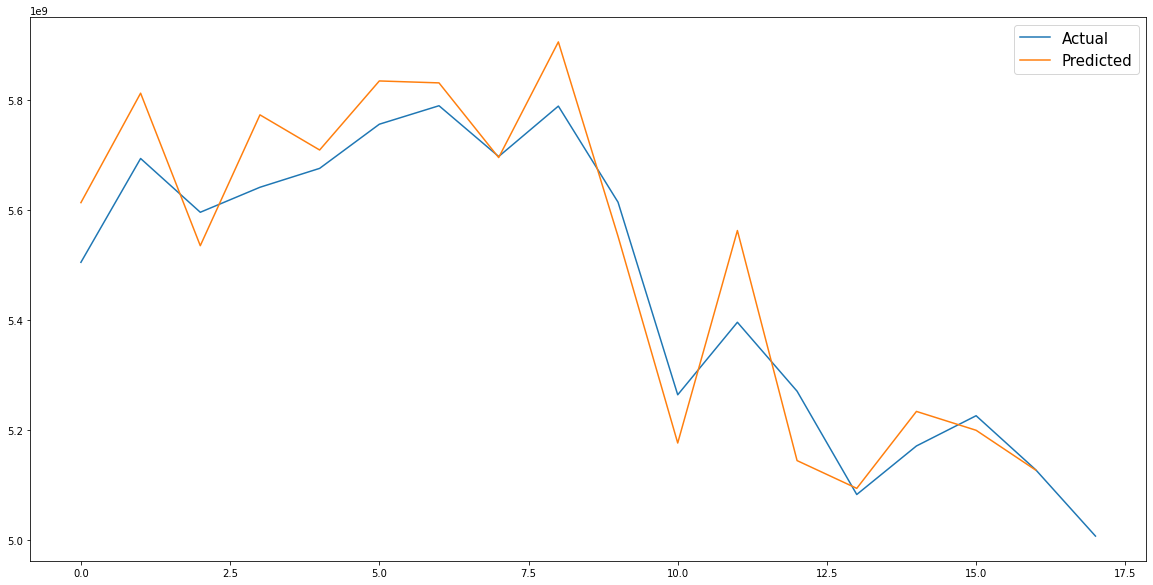

In [31]:
# Plot the actual observations and predictions again.
plt.figure(figsize=(20,10))
plt.plot(test["Total_Emission"],label="Actual")
plt.plot(predictions["Predicted Total Emission"],label="Predicted")
plt.legend(fontsize=15)
plt.show()

##### Much better this time. Next, put the year, actual CO2 Emissions and Predictions into one dataframe and calculate the absolute error for each year in the test data.

In [32]:
year=df[["Year"]]
train_year, test_year = year[0:size], year[size:len(X)]
test_year=test_year.reset_index(drop=True)
test_year

,Year
0,1999
1,2000
2,2001
3,2002
4,2003
5,2004
6,2005
7,2006
8,2007
9,2008


In [33]:
test=pd.concat([test_year,test,predictions],axis=1)
test["Absolute Errors"]=np.abs(test["Total_Emission"]-predictions["Predicted Total Emission"])
test=test.dropna()
test

,Year,Total_Emission,Predicted Total Emission,Absolute Errors
0,1999,5.504669e+09,5.613326e+09,1.086571e+08
1,2000,5.693685e+09,5.812588e+09,1.189031e+08
2,2001,5.595794e+09,5.534949e+09,6.084569e+07
3,2002,5.641309e+09,5.773121e+09,1.318114e+08
4,2003,5.675702e+09,5.709135e+09,3.343304e+07
5,2004,5.756075e+09,5.834838e+09,7.876266e+07
6,2005,5.789727e+09,5.831325e+09,4.159753e+07
7,2006,5.697286e+09,5.695356e+09,1.929752e+06
8,2007,5.789031e+09,5.905917e+09,1.168863e+08
9,2008,5.614111e+09,5.551921e+09,6.219024e+07


##### Use the model to forecast. This is different from predicting. When we predict, we have actual observations, the test data, to compare our predictions to. When we forecast, we want to know what has not happened yet. So, there is no actual observations to compare the forecast values to. We want to see whether the U.S. would be able to achieve net-zero emission by mid-century. So, we are going to forecast from the last year in the table above till 2050. We also want to use the 99% confidence interval. So, set alpha to be 0.01.

In [34]:
fc, se, conf=model_fit.forecast(2050-test["Year"].max(),alpha=0.01)

In [40]:
forecast=pd.DataFrame(fc).rename(columns={0:"Forecast total CO2 emission"})
years=pd.DataFrame(np.arange(2016,2051)).rename(columns={0:"Year"})
forecast=pd.concat([years,forecast],axis=1)
forecast.tail()

,Year,Forecast total CO2 emission
30,2046,6.301499e+09
31,2047,6.342157e+09
32,2048,6.382816e+09
33,2049,6.423474e+09
34,2050,6.464133e+09


In [43]:
fig = px.bar(forecast, x='Year', y='Forecast total CO2 emission',title="Forecast CO2 Emissions in the U.S. in Metric Tons, 2016 - 2050")
fig.show()

###### According to the forecast, the U.s. will be emitting more and more CO2 each year. The forecast projects that the U.S. will emit 6.465 billion metric tons of CO2 into the atmosphere. That is 129.3% of the amount of CO2 released in 2016.

##### Following is net emission in the U.S. from 2005 to 2019, obtained from the [United States Environmental Protection Agency](https://www.epa.gov/sites/production/files/2021-04/documents/fastfacts-1990-2019.pdf.pdf).

In [44]:
data={"Year":[2005,2015,2016,2017,2018,2019],"Net emission":[6635,5907.3,5677.5,5717.2,5870,5769.1]}
net=pd.DataFrame(data=data)
net

,Year,Net emission
0,2005,6635.0
1,2015,5907.3
2,2016,5677.5
3,2017,5717.2
4,2018,5870.0
5,2019,5769.1


In [48]:
decrease=round((net.at[0,"Net emission"]-net.at[len(net)-1,"Net emission"])/net.at[0,"Net emission"],4)
print("From 2005 to 2019, net emission in the U.S. decreased by ",decrease*100 , "%.")


From 2005 to 2019, net emission in the U.S. decreased by  13.05 %.


##### Net emission decreased by 13.05% over the course of 14 years. At this rate, what will the the approximate net emission in 2050?

In [50]:
est=round(net.at[len(net)-1,"Net emission"]*(1-((2050-2019)/14)*decrease),2)
print ("At current rate, net emission in the U.S. will be ",est," metric tons.")

At current rate, net emission in the U.S. will be  4102.04  metric tons.


##### Forecast total emission for 2050 is 6465 metric tons. That means the U.S. will be far short of its net zero goal in 2050.